In [1]:
# Modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import scipy

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = (16,12)

In [3]:
# Data Slicing 
def dd_1418(df, year):
    df = df[df['구분'] == '전국']
    df = df.iloc[:, [3,4,11,23,24]]
    df = df.rename(columns={'Unnamed: 3' : '발생', 'Unnamed: 11' : year})
    df = df.set_index('발생')
    df = df.astype('float64')
    df.iloc[0,1] = df.iloc[0,1] + df.iloc[0,2] + df.iloc[0,3]
    df.iloc[3,1] = df.iloc[3,1] + df.iloc[3,2] + df.iloc[3,3]
    df = df[[year]]
    return df

def dd_1920(df, year):
    df = df[df['시도'] == '전국']
    df = pd.concat([df[df['Unnamed: 3'] == '폐합성수지류'], df[df['Unnamed: 2'] == '폐합성수지류']])
    df = df.iloc[:, [0,4,5,6,7,8]]
    df.iloc[:,1:] = df.iloc[:, 1:].astype('float64')
    df.iloc[0,1] = df.iloc[0,1] + df.iloc[1,1] + df.iloc[2,1] + df.iloc[3,1] + df.iloc[4,1]
    df.iloc[0,2] = df.iloc[0,2] + df.iloc[1,1] + df.iloc[2,1] + df.iloc[3,1] + df.iloc[4,1]
    target_str = str(year) + '발생량'
    df = df.rename(columns={target_str : '발생량',
                            '총계' : '재활용',
                            'Unnamed: 6' : '소각',
                            'Unnamed: 7' : '매립',
                            'Unnamed: 8' : '기타'})
    #df = df.iloc[0, 1:]
    df.index = [year,1,2,3,4]
    df = df[['발생량','매립','소각','재활용','기타']]
    return df.T[[year]].div(365).round(0)

In [4]:
# Load Data
df_2014 = dd_1418(pd.read_csv('./data/trash_2014.csv'), 2014)
df_2015 = dd_1418(pd.read_csv('./data/trash_2015.csv'), 2015)
df_2016 = dd_1418(pd.read_csv('./data/trash_2016.csv'), 2016)
df_2017 = dd_1418(pd.read_csv('./data/trash_2017.csv'), 2017)
df_2018 = dd_1418(pd.read_csv('./data/trash_2018.csv'), 2018)
df_2019 = dd_1920(pd.read_csv("./data/trash_2019.csv"), 2019)
df_2020 = dd_1920(pd.read_csv("./data/trash_2020.csv"), 2020)

# Data Concatenation
df_sum = pd.concat([df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020], axis=1).fillna(0)
df_sum = df_sum.T.reset_index()

In [5]:
year = np.array(df_sum['index'].to_list())
total = np.array(df_sum['발생량'].to_list())
buried = np.array(df_sum['매립'].to_list())
burned = np.array(df_sum['소각'].to_list())
recycled = np.array(df_sum['재활용'].to_list())
etc = np.array(df_sum['기타'].to_list())

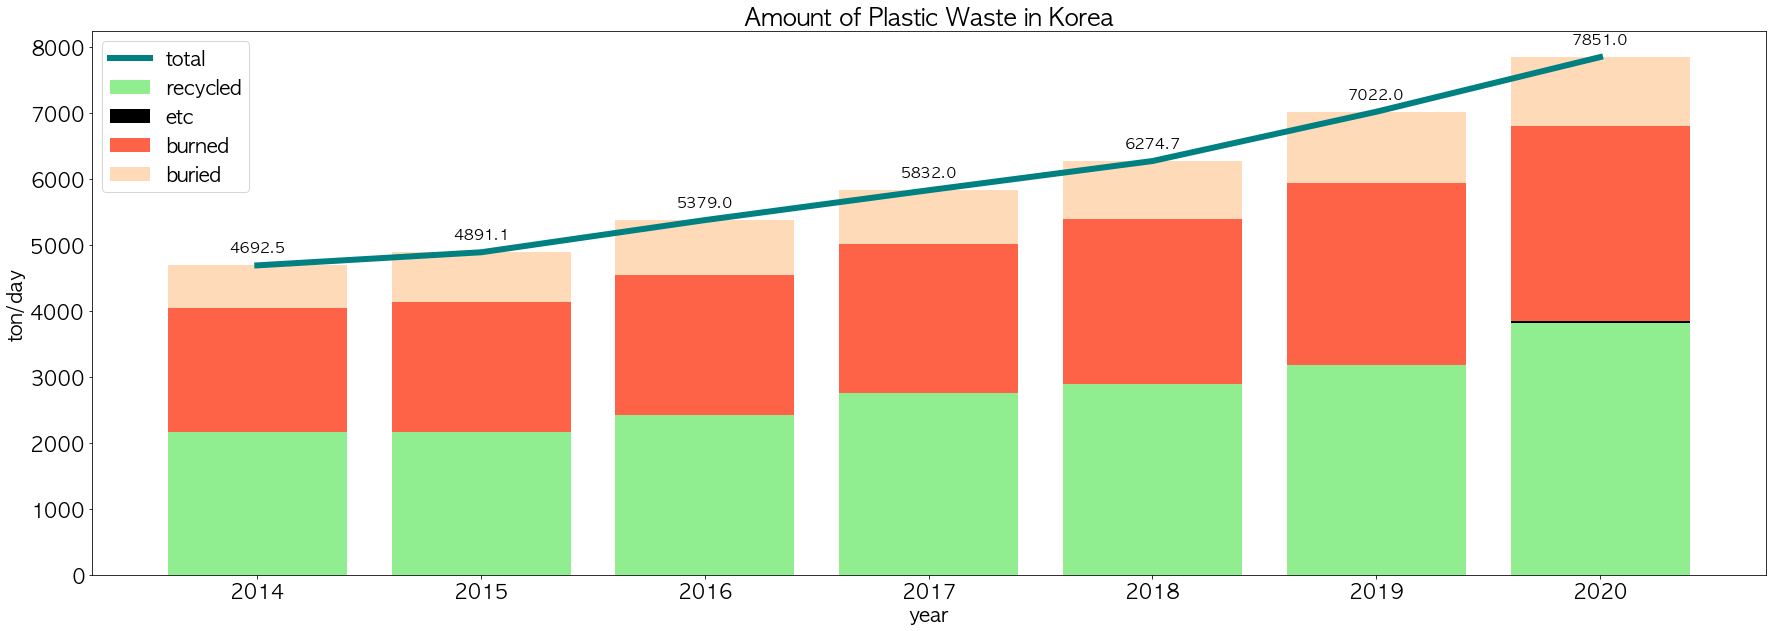

In [7]:
plt.rcParams['figure.figsize'] = (30,10)
plt.rcParams['font.size'] = 20
plt.bar(year, recycled, color='#90EE90', label='recycled')
plt.bar(year, etc, color='#000000', label='etc', bottom=recycled)
plt.bar(year, burned, color='#FF6347', label='burned', bottom=recycled+etc)
plt.bar(year, buried, color='#FFDAB9', label='buried', bottom=recycled+burned+etc)
plt.plot(year, total, color='#008080', linewidth=6, label='total')
plt.legend()
plt.title("Amount of Plastic Waste in Korea")
plt.ylabel('ton/day')
plt.xlabel('year')

for i in range(7):
    height = total[i]
    plt.text(year[i], height+150, '%.1f' %height, ha='center', va='bottom', size=15)

# Savefig
#plt.savefig('./plots/plastic_amount.png', dpi=300, bbox_inches='tight')

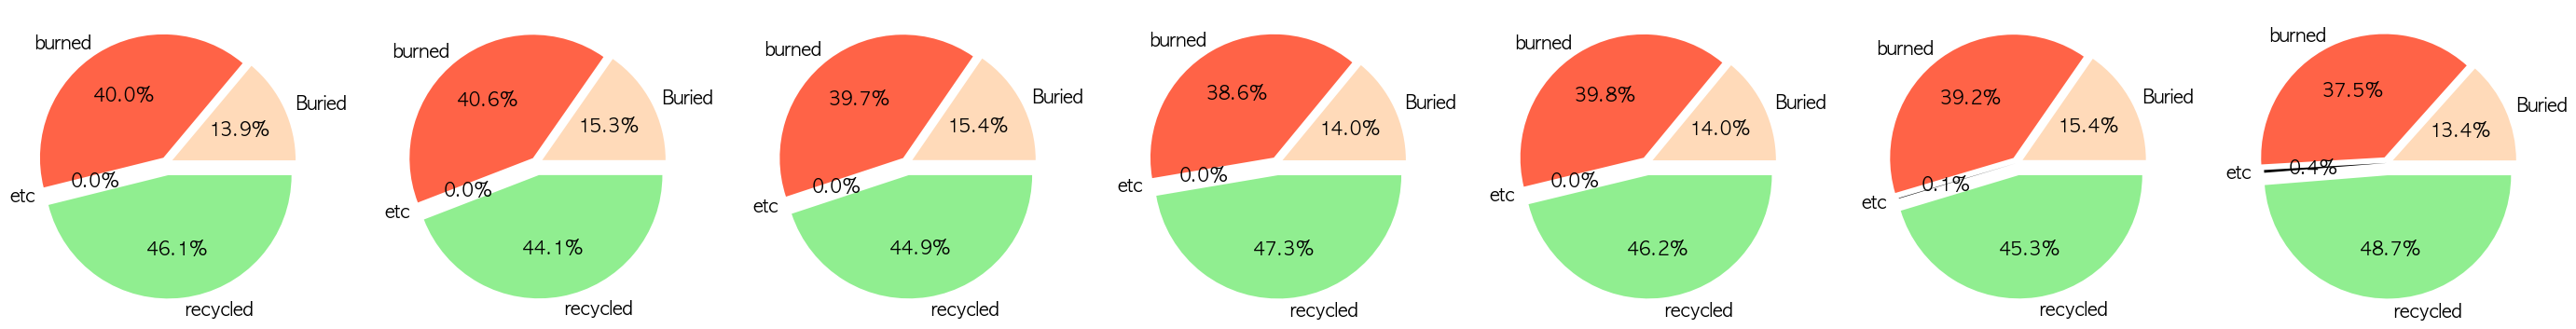

In [9]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (35,5)
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'AppleGothic'
color__ = ['#FFDAB9', '#FF6347', '#000000', '#90EE90']
explode__ = [0.05, 0.05, 0, 0.1]
for i in range(7):
    plt.subplot(1,7,i+1)
    temp_data = [buried[i], burned[i], etc[i], recycled[i]]
    temp_label = ['Buried', 'burned', 'etc', 'recycled']
    plt.pie(temp_data, labels=temp_label, autopct='%.1f%%', colors=color__, explode=explode__)

# Savefig
#plt.savefig('./plots/plastic_amount_percent.png', dpi=300, bbox_inches='tight')

In [11]:
train_year = np.arange(2014,2021)
train_amount = total

# Fitting with Exponential Model
def exp_model(w):
  pred = w[0]*np.exp(-w[1]*(train_year-2014))
  SSE = np.sum((train_amount - pred)**2)
  return SSE

start_pt = np.random.random(2)
LSE_results = scipy.optimize.minimize(exp_model, start_pt, method='nelder-mead')

model_t = np.arange(2020, 2030.1,.1)
pred_LSE = LSE_results['x'][0]*np.exp(-LSE_results['x'][1]*(model_t-2014))
# To f-string
exp_func = f"y = {round(LSE_results['x'][0], 1)} * exp({round(-LSE_results['x'][1], 1)}(x-2014))"

# Also Fitting with Linear Model
lr_plastics = LinearRegression()
lr_plastics.fit(train_year.reshape(-1,1), train_amount)
# To f-string
linear_func = f"y = {round(lr_plastics.coef_[0], 1)}x + {round(lr_plastics.intercept_, 1)}"

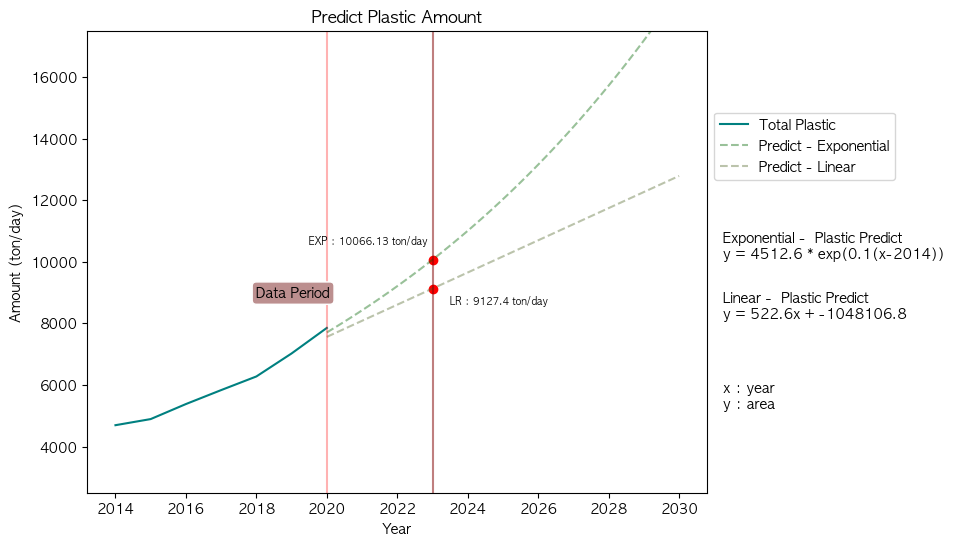

In [13]:
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 10
plt.rc('axes', unicode_minus=False)

plt.plot(train_year, train_amount, label='Total Plastic', color='#008080')
plt.plot(model_t, pred_LSE, label='Predict - Exponential', color='#006400', ls='--', alpha=0.4)  # Exponential
plt.plot(model_t, lr_plastics.predict(model_t.reshape(-1,1)), label='Predict - Linear', color='#556B2F', ls='--', alpha=0.4)  # Linear

# Data Period
plt.vlines(2020, 0, 20000, colors="red", alpha=0.3)
plt.text(2018, total[-1]+1000, "Data Period", bbox={'boxstyle' : 'round', 'ec' : '#FFFFFF', 'fc' : "#BC8F8F"})

# Year 2023
plt.vlines(2023, 0, 20000, colors="#800000", alpha=0.5)
lr_pred = round(lr_plastics.predict(np.array([2023]).reshape(-1,1))[0], 2)
plt.scatter(2023, lr_pred, color="red")
plt.text(2023.5, lr_pred-500, f"LR : {lr_pred} ton/day", size=7)
exp_pred = round(LSE_results['x'][0] * np.exp(-LSE_results['x'][1] * (2023-2014)), 2)
plt.text(2019.5, exp_pred+500, f"EXP : {exp_pred} ton/day", size=7)
plt.scatter(2023, exp_pred, color="red")

plt.title("Predict Plastic Amount")
plt.ylim(2500,17500)
plt.xlabel('Year')
plt.ylabel('Amount (ton/day)')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.75))
plt.gcf().text(0.92, 0.5, "Exponential -  Plastic Predict\n" + exp_func, fontsize=10)
plt.gcf().text(0.92, 0.4, "Linear -  Plastic Predict\n" + linear_func, fontsize=10)
plt.gcf().text(0.92, 0.25, "x : year\ny : area", fontsize=10)

# Savefig
#plt.savefig('./plots/plastic_predict.png', dpi=300, bbox_inches='tight')